In [1]:
%load_ext autoreload
%autoreload 2
    
import scprinter as scp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import time
import pandas as pd
import numpy as np
import os
import time
import re
import pyBigWig
import numpy as np
import pandas as pd
from concurrent.futures import *
from tqdm.auto import *
import pickle

# Train a finetuned TFBS model

In [9]:
feats = ['attr.count.shap_hypo_0_.0.85.bigwig',
         'attr.just_sum.shap_hypo_0-30_.0.85.bigwig',
        ]

In [10]:
tsv_paths = {
    'HepG2_0': "/data/rzhang/PRINT_rev/HepG2/TF_prediction.tsv",
    'HepG2_1': "/data/rzhang/PRINT_rev/HepG2/TF_prediction.tsv",
    'HepG2_2': "/data/rzhang/PRINT_rev/HepG2/TF_prediction.tsv",
    'HepG2_3': "/data/rzhang/PRINT_rev/HepG2/TF_prediction.tsv",
    'HepG2_4': "/data/rzhang/PRINT_rev/HepG2/TF_prediction.tsv",
    'GM12878_0': "/data/rzhang/PRINT_rev/GM12878/GM12878_pred_data.tsv",
    'GM12878_1': "/data/rzhang/PRINT_rev/GM12878/GM12878_pred_data.tsv",
    'GM12878_2': "/data/rzhang/PRINT_rev/GM12878/GM12878_pred_data.tsv",
    'GM12878_3': "/data/rzhang/PRINT_rev/GM12878/GM12878_pred_data.tsv",
    'GM12878_4': "/data/rzhang/PRINT_rev/GM12878/GM12878_pred_data.tsv",
    'K562': "/data/rzhang/PRINT_rev/K562/K562_pred_data.tsv",
    'A549': "/data/rzhang/PRINT_rev/A549/A549_pred_data.tsv"
}
peaks_path = {
    'HepG2_0': "/data/rzhang/PRINT_rev/HepG2/peaks.bed",
    'HepG2_1': "/data/rzhang/PRINT_rev/HepG2/peaks.bed",
    'HepG2_2': "/data/rzhang/PRINT_rev/HepG2/peaks.bed",
    'HepG2_3': "/data/rzhang/PRINT_rev/HepG2/peaks.bed",
    'HepG2_4': "/data/rzhang/PRINT_rev/HepG2/peaks.bed",
    'GM12878_0': "/data/rzhang/PRINT_rev/GM12878/peaks.bed",
    'GM12878_1': "/data/rzhang/PRINT_rev/GM12878/peaks.bed",
    'GM12878_2': "/data/rzhang/PRINT_rev/GM12878/peaks.bed",
    'GM12878_3': "/data/rzhang/PRINT_rev/GM12878/peaks.bed",
    'GM12878_4': "/data/rzhang/PRINT_rev/GM12878/peaks.bed",
    'K562': "/data/rzhang/PRINT_rev/K562/peaks.bed",
    'A549': "/data/rzhang/PRINT_rev/A549/peaks.bed",
}

model_name = {
    'HepG2_0': ["/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_fold0-crimson-bao-8.pt_deepshap"],
    'HepG2_1': ["/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_fold1-auspicious-rocket-9.pt_deepshap"],
    'HepG2_2': ["/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_fold2-prosperous-fish-8.pt_deepshap"],
    'HepG2_3': ["/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_fold3-prosperous-bao-11.pt_deepshap"],
    'HepG2_4': ["/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_fold4-radiant-paper-12.pt_deepshap"],
    'GM12878_0': ["/data/rzhang/PRINT_rev/GM12878/final_model/GM12878_fold0-flashing-envelope-23.pt_deepshap"],
    'GM12878_1': ["/data/rzhang/PRINT_rev/GM12878/final_model/GM12878_fold1-thriving-dog-24.pt_deepshap"],
    'GM12878_2': ["/data/rzhang/PRINT_rev/GM12878/final_model/GM12878_fold2-dazzling-dog-21.pt_deepshap"],
    'GM12878_3': ["/data/rzhang/PRINT_rev/GM12878/final_model/GM12878_fold3-vivid-chrysanthemum-21.pt_deepshap"],
    'GM12878_4': ["/data/rzhang/PRINT_rev/GM12878/final_model/GM12878_fold4-legendary-festival-25.pt_deepshap"],

    'K562': ["/data/rzhang/PRINT_rev/K562/final_model/K562_fold0-flashing-snake-6.pt_deepshap_wo_norm",
             "/data/rzhang/PRINT_rev/K562/final_model/K562_fold1-abundant-envelope-1.pt_deepshap_wo_norm",
             "/data/rzhang/PRINT_rev/K562/final_model/K562_fold2-luminous-fireworks-1.pt_deepshap_wo_norm",
             "/data/rzhang/PRINT_rev/K562/final_model/K562_fold3-auspicious-laughter-1.pt_deepshap_wo_norm",
             "/data/rzhang/PRINT_rev/K562/final_model/K562_fold4-glistening-peony-7.pt_deepshap_wo_norm"],
    'A549': ["/data/rzhang/PRINT_rev/A549/final_model/A549_fold0-glittering-wonton-28.pt_deepshap",
             "/data/rzhang/PRINT_rev/A549/final_model/A549_fold1-cheerful-fish-29.pt_deepshap",
             "/data/rzhang/PRINT_rev/A549/final_model/A549_fold2-filigreed-dog-27.pt_deepshap",
             "/data/rzhang/PRINT_rev/A549/final_model/A549_fold3-crimson-fuse-26.pt_deepshap",
             "/data/rzhang/PRINT_rev/A549/final_model/A549_fold4-radiant-pig-30.pt_deepshap"]
}


In [11]:

def read_TF_loci(path):
    TF_prediction = pd.read_csv(path, sep='\t')
    if 'range' in TF_prediction.columns:
        ranges = pd.DataFrame([re.split(':|-', xx) for xx in TF_prediction['range']])
        ranges = ranges[[0,1,2,3]]
        v = np.array(ranges[3])
        v[v == ''] = '-'
        ranges[3] = v
        ranges.columns = ['chrom','start','end', 'strand']
        ranges['start'] = ranges['start'].astype('int')
        ranges['end'] = ranges['end'].astype('int')
        TF_prediction = pd.concat([TF_prediction, ranges], axis=1)
    else:
        TF_prediction = pd.read_csv(path, sep='\t', header=None)
        TF_prediction.columns = ['chrom','start','end', 'bound', 'TF']
        TF_prediction['strand'] = '+'
    # TF_prediction = TF_prediction.sort_values(by=['bound'], ascending=False) # sort such that bound = 1, comes first, and will be kept.
    TF_prediction['summit'] = (TF_prediction['start']-1 + TF_prediction['end']) // 2
    # TF_prediction = TF_prediction.drop_duplicates(['chrom','start', 'end'])
    # TF_prediction = TF_prediction[TF_prediction['chrom'].isin(['chr1', 'chr3', 'chr6'])]
    return TF_prediction

def read_peaks(path):
    df = pd.read_csv(path, sep='\t', header=None)
    df.columns = ['chrom', 'start', 'end']
    print (df)
    return df

def get_normalization_factor(model, feat, peak, low=0.05, 
                             median = 0.5,
                             high=0.95, sample_num=30000):
    vs = []
    with pyBigWig.open(f"{model}/{feat}", 'r') as f:
        chroms = f.chroms().keys()
        print (chroms)
        peaks = peak[peak['chrom'].isin(chroms)].copy()
        peaks['summit'] = (peaks['start'] + peaks['end']) // 2
        peaks['start'] = peaks['summit'] - 400
        peaks['end'] = peaks['summit'] + 400
        if sample_num > 0:
            peaks = peaks.sample(sample_num, replace=True).copy()
        for chrom, start, end in zip(peaks['chrom'], peaks['start'], peaks['end']):
            v = f.values(chrom, int(start), int(end), numpy=True)
            vs.append(v)
            
    vs = np.concatenate(vs)
    vs = np.nan_to_num(vs)
    return np.quantile(vs, low), np.quantile(vs, median), np.quantile(vs, high)
motifs = scp.motifs.Motifs("./human_pfms_v4.txt", 
                           scp.genome.hg38.fetch_fa(), scp.genome.hg38.bg)
motif2matrix = {motif.name.split("_")[2]: np.array([motif.counts['A'], motif.counts['C'], motif.counts['G'], motif.counts['T']]) for motif in motifs.all_motifs}

In [12]:
for m in motif2matrix:
    mm = motif2matrix[m]
    # print (mm.shape)
    mm = mm / np.sum(mm, axis=0, keepdims=True)
    motif2matrix[m] = mm

In [13]:
tsvs = {cell:read_TF_loci(tsv_paths[cell]) for cell in tsv_paths}
peaks = {cell:read_peaks(peaks_path[cell]) for cell in peaks_path}

      chrom      start        end
0      chr1     777315     778314
1      chr1     778196     779195
2      chr1     816901     817900
3      chr1     826966     827965
4      chr1     842352     843351
...     ...        ...        ...
81722  chrX  155880804  155881803
81723  chrX  155986693  155987692
81724  chrX  155997237  155998236
81725  chrX  156001287  156002286
81726  chrX  156006076  156007075

[81727 rows x 3 columns]


In [15]:

pool= ProcessPoolExecutor(max_workers=100)
norm_factor = {}
p_list = []
for cell in model_name:
    norm_factor[cell] = {}
    for feat in feats:
        norm_factor[cell][feat] = []
        for model in model_name[cell]:
            p = pool.submit(get_normalization_factor,model, 
                                                   feat,
                                                   peaks[cell], sample_num=-1)
            norm_factor[cell][feat].append(p)
            p_list.append(p)
for p in tqdm(as_completed(p_list), total=len(p_list)):
    continue
for cell in model_name:
    for feat in feats:
        for i, model in enumerate(model_name[cell]):
            norm_factor[cell][feat][i] = norm_factor[cell][feat][i].result()
            

dict_keys(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX'])

  0%|          | 0/10 [00:00<?, ?it/s]


dict_keys(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX'])
dict_keys(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX'])
dict_keys(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX'])
dict_keys(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX'])
dict_keys(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'ch

In [16]:
for cell in model_name:
    for feat in feats:
        for i, model in enumerate(model_name[cell]):
            lo, mid,hi = norm_factor[cell][feat][i]
            print (cell, feat, i, "%.2f" % mid, "%.2f"%(hi-lo))

K562 attr.count.shap_hypo_0_.0.85.bigwig 0 0.00 1.20
K562 attr.count.shap_hypo_0_.0.85.bigwig 1 0.00 1.23
K562 attr.count.shap_hypo_0_.0.85.bigwig 2 0.00 1.22
K562 attr.count.shap_hypo_0_.0.85.bigwig 3 0.00 1.20
K562 attr.count.shap_hypo_0_.0.85.bigwig 4 0.00 1.21
K562 attr.just_sum.shap_hypo_0-30_.0.85.bigwig 0 0.00 1.18
K562 attr.just_sum.shap_hypo_0-30_.0.85.bigwig 1 0.00 1.16
K562 attr.just_sum.shap_hypo_0-30_.0.85.bigwig 2 0.00 1.16
K562 attr.just_sum.shap_hypo_0-30_.0.85.bigwig 3 0.00 1.18
K562 attr.just_sum.shap_hypo_0-30_.0.85.bigwig 4 0.00 1.18


In [17]:
from pyfaidx import Fasta
from scipy.stats import *
def cosine(x,y):
    return (x*y).sum() / (np.linalg.norm(x) * np.linalg.norm(y))
    # return spearmanr(x, y)[0]
def get_feats(model, feat, tsv,
              flank,
              low=None, median=None, high=None, chroms = None,
             verbose=False):
    if low is None:
        low = 0
        median = 0
        high = 1
    fasta = Fasta(scp.genome.hg38.fetch_fa())
    signals = []
    similarity = []
    strengths = []
    with pyBigWig.open(f"{model}/{feat}", 'r') as f:
        if chroms is None:
            chroms = f.chroms().keys()
        tsv = tsv[tsv['chrom'].isin(chroms)].copy()
        chrom, summit, strand = np.array(tsv['chrom']), np.array(tsv['summit']), np.array(tsv['strand'])
        starts, ends, strands = np.array(tsv['start']), np.array(tsv['end']), np.array(tsv['strand'])
        tfs = np.array(tsv['TF'])
        labels = np.array(tsv['bound'])

        
        for c,s,sd,tf, start,end in zip(tqdm(chrom, disable=not verbose), summit, strands, tfs, starts, ends):
            
            try:
                v = f.values(c, s-flank, s+flank+1, numpy=True)
            except:
                print (c, s-flank, s+flank+1)
                v = np.zeros((int(2*flank+1)))
            if sd != '+':
                v = v[::-1]

            # seq = hg38.fetch_onehot_seq(c, start-1, end).numpy()
            seq = fasta[c][start-1:end].seq
            seq = scp.utils.DNA_one_hot(seq).numpy()
            seq_trend = f.values(c, start-1, end, numpy=True)
            if sd == '-':
                seq = seq[::-1][:, ::-1]
                seq_trend = seq_trend[::-1]
            motif_trend = (motif2matrix[tf] * seq).sum(axis=0)
            motif_match = cosine(motif2matrix[tf].reshape((-1)), seq.reshape((-1)))
            
            signals.append(v)
            similarity.append([cosine(seq_trend, motif_trend), 
                               # motif_match,
                               ((seq_trend - median) / (high - low)).mean()])
    
    signals = np.array(signals)
    similarity = np.array(similarity)
    signals = np.nan_to_num(signals)
    similarity =  np.nan_to_num(similarity)

    # for tf in np.unique(tfs):
    #     mask = tfs == tf
    #     v = similarity[mask]
    #     v = (v - np.min(v, axis=0, keepdims=True)) / (np.max(v, axis=0, keepdims=True) - np.min(v, axis=0, keepdims=True))
    #     similarity[mask] = v

    
    signals = (signals - median) / (high - low)
    return signals, similarity, tsv

In [18]:
feats_all = {}
labels_all = {}
pool= ProcessPoolExecutor(max_workers=200)
p_list = []
for cell in model_name:
    for feat in feats:
        for i, model in enumerate(model_name[cell]):
            # lo, mid, hi = norm_factor[cell][feat][i]
            # lo, mid, hi = 0,0,1
            lo, mid, hi = None, None, None
            p_list.append(pool.submit(get_feats,model, feat, tsvs[cell], 
                  100,
                  lo, mid, hi))

for p in tqdm(as_completed(p_list), total=len(p_list)):
    continue
ct = 0
for cell in model_name:
    feats_cell = []
    sims_cell = []
    for feat in feats:
        feats_v = 0
        sims_v = 0
        for i, model in enumerate(model_name[cell]):
            feats_, sims_, labels = p_list[ct].result()
            ct += 1
            feats_v += feats_
            sims_v += sims_
        feats_v = feats_v / len(model_name[cell])
        sims_v = sims_v / len(model_name[cell])
        feats_cell.append(feats_v)
        sims_cell.append(sims_v)
    feats_cell = np.stack(feats_cell, axis=1)
    sims_cell = np.stack(sims_cell, axis=1)
    # print (feats_cell.shape, sims_cell.shape)
    feats_all[cell] = [feats_cell, sims_cell]
    labels_all[cell] = labels
pool.shutdown(wait=True)

  0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
from sklearn.model_selection import train_test_split
hepg2_train, hepg2_val = train_test_split(np.arange(len(labels_all['HepG2_0'])), test_size=0.1, random_state=42)
gm_train, gm_val = train_test_split(np.arange(len(labels_all['GM12878_0'])), test_size=0.1, random_state=42)


In [27]:
train_cells_hepg2 = ['HepG2_0', 
             'HepG2_1', 
             'HepG2_2', 
             'HepG2_3', 
             'HepG2_4'
                    ]
train_cells_gm12878 = ['GM12878_0',
             'GM12878_1',
             'GM12878_2',
             'GM12878_3',
             'GM12878_4'
                      ]

In [28]:
def feats_for_cell(feats_all, labels_all, cell, window=201, n_feats=np.arange(8)):
    seq_attr = feats_all[cell][0]
    pad = (seq_attr.shape[-1] - window) // 2
    if pad > 0:
        seq_attr = seq_attr[..., pad:-pad]
    # seq_attr = seq_attr[:, n_feats].reshape((len(seq_attr), -1))
    seq_motif_sim = feats_all[cell][1][:, n_feats]
    motifs = np.asarray(labels_all[cell]['motifMatchScore'])[:, None]
    motifs = np.stack([motifs] * len(n_feats), axis=1)
    # feats = seq_motif_sim.reshape((len(seq_attr), -1))
    feats = np.concatenate([motifs, seq_motif_sim, seq_attr], axis=-1)
    print (motifs.shape, seq_motif_sim.shape, seq_attr.shape)
    return feats

In [ ]:
train_feats = np.concatenate([feats_for_cell(feats_all, labels_all, cell,n_feats=np.arange(2))[hepg2_train] for cell in train_cells_hepg2] + 
                            [feats_for_cell(feats_all, labels_all, cell,n_feats=np.arange(2))[gm_train] for cell in train_cells_gm12878], axis=0)

valid_feats = np.concatenate([feats_for_cell(feats_all, labels_all, cell,n_feats=np.arange(2))[hepg2_val] for cell in train_cells_hepg2] + 
                            [feats_for_cell(feats_all, labels_all, cell,n_feats=np.arange(2))[gm_val] for cell in train_cells_gm12878], axis=0)

train_labels = np.concatenate([np.asarray(labels_all[cell]['bound'])[hepg2_train] for cell in train_cells_hepg2] + 
[np.asarray(labels_all[cell]['bound'])[gm_train] for cell in train_cells_gm12878], axis=0)
valid_labels = np.concatenate([np.asarray(labels_all[cell]['bound'])[hepg2_val] for cell in train_cells_hepg2] + [np.asarray(labels_all[cell]['bound'])[gm_val] for cell in train_cells_gm12878], axis=0)

In [16]:
import pickle
pickle.dump([train_feats, valid_feats, train_labels, valid_labels], open("finetune_TFBS.pkl", "wb"))

In [ ]:
train_feats = np.concatenate(
                            [feats_for_cell(feats_all, labels_all, cell,n_feats=np.arange(2))[gm_train] for cell in train_cells_gm12878], axis=0)

valid_feats = np.concatenate(
                            [feats_for_cell(feats_all, labels_all, cell,n_feats=np.arange(2))[gm_val] for cell in train_cells_gm12878], axis=0)

train_labels = np.concatenate(
[np.asarray(labels_all[cell]['bound'])[gm_train] for cell in train_cells_gm12878], axis=0)
valid_labels = np.concatenate([np.asarray(labels_all[cell]['bound'])[gm_val] for cell in train_cells_gm12878], axis=0)

In [ ]:
import pickle
pickle.dump([train_feats, valid_feats, train_labels, valid_labels], open("finetune_TFBS_GM.pkl", "wb"))

In [ ]:
import argparse
import pickle

import numpy as np
import torch.nn.functional as F
from sklearn.metrics import average_precision_score


# Validation step with AUPR reporting
def validate_model(model, val_loader, criterion, device="cpu"):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to compute gradient when evaluating
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)[..., 0, :]
            val_loss += criterion(outputs, labels.float()).item()

            # # Store predictions and labels
            all_preds.extend(torch.sigmoid(outputs).cpu().numpy())  # Assuming binary classification
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_loss *= 100
    val_aupr = average_precision_score(all_labels, all_preds)  # Compute AUPR
    return val_loss, val_aupr


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from scprinter.backup.ema import EMA


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = nn.functional.cross_entropy(inputs, targets, reduction="none")
        else:
            BCE_loss = nn.functional.binary_cross_entropy_with_logits(
                inputs, targets, reduction="none"
            )
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss


# 1. Define the MLP Model
class MLP(nn.Module):
    def __init__(self, input_size, input_channel, mean, scale):
        super(MLP, self).__init__()
        self.mean = nn.Parameter(torch.from_numpy(mean).float())
        self.scale = nn.Parameter(torch.from_numpy(scale).float())
        self.fc1 = nn.Linear((input_size) * input_channel, 256)  # First hidden layer
        self.activation1 = nn.GELU()
        self.dropout1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(256, 128)  # Second hidden layer
        self.activation2 = nn.GELU()
        self.dropout2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(128, 64)  # Output layer, assuming 10 classes
        self.activation3 = nn.GELU()
        self.dropout3 = nn.Dropout(0.25)
        self.fc4 = nn.Linear(64, 1)  # Output layer, assuming 10 classes

        # self.fc5 = nn.Linear(3, 1)

    def forward(self, x):
        x = (x - self.mean[-x.shape[-1] :]) / self.scale[-x.shape[-1] :]
        xx = self.dropout1(self.activation1(self.fc1(x[..., :].reshape(x.shape[0], -1))))
        xx = self.dropout2(self.activation2(self.fc2(xx)))
        xx = self.dropout3(self.activation3(self.fc3(xx)))
        xx = self.fc4(xx)  # No activation, will use nn.CrossEntropyLoss
        # xx = xx + self.fc5(x[..., :3].mean(dim=1))
        return xx


class TFConv(nn.Module):
    def __init__(self, input_size, input_channel, mean, scale):
        super(TFConv, self).__init__()
        self.mean = nn.Parameter(torch.from_numpy(mean).float())
        self.scale = nn.Parameter(torch.from_numpy(scale).float())
        self.mean.requires_grad = False
        self.scale.requires_grad = False
        self.input_size = input_size
        self.input_channel = input_channel

        self.conv1 = nn.Conv1d(input_channel, 256, input_size)
        self.activation1 = nn.GELU()
        self.dropout1 = nn.Dropout(0.25)
        self.conv2 = nn.Conv1d(256, 128, 1)
        self.activation2 = nn.GELU()
        self.dropout2 = nn.Dropout(0.25)
        self.conv3 = nn.Conv1d(128, 64, 1)
        self.activation3 = nn.GELU()
        self.dropout3 = nn.Dropout(0.25)
        self.conv4 = nn.Conv1d(64, 1, 1)

    def forward(self, x):

        if x.shape[-1] != self.mean.shape[-1]:
            x = (x - self.mean[3:]) / self.scale[3:]
            x = torch.cat(
                [
                    torch.zeros([x.shape[0], x.shape[1], 3], device=x.device, dtype=x.dtype),
                    x,
                ],
                dim=2,
            )
        else:
            x = (x - self.mean) / self.scale
        # x = (x - self.mean) / self.scale
        xx = self.dropout1(self.activation1(self.conv1(x)))
        xx = self.dropout2(self.activation2(self.conv2(xx)))
        xx = self.dropout3(self.activation3(self.conv3(xx)))
        xx = self.conv4(xx)
        return xx


class TFConv_translate(nn.Module):
    def __init__(self, tfconv):
        super(TFConv_translate, self).__init__()
        # self = deepcopy(tfconv)
        print(
            tfconv.conv1.weight.shape,
            tfconv.conv1.bias.shape,
            tfconv.mean.shape,
            tfconv.scale.shape,
        )
        new_weight_0 = 1 / tfconv.scale[None] * tfconv.conv1.weight[:, 0, :]
        new_weight_1 = (
            tfconv.conv1.bias - (tfconv.mean / tfconv.scale) @ tfconv.conv1.weight[:, 0, :].T
        )
        print(new_weight_0.shape, new_weight_1.shape)

        self.conv1 = nn.Conv1d(tfconv.input_channel, 256, tfconv.input_size)
        self.activation1 = nn.GELU()
        self.dropout1 = nn.Dropout(0.25)
        self.conv2 = nn.Conv1d(256, 128, 1)
        self.activation2 = nn.GELU()
        self.dropout2 = nn.Dropout(0.25)
        self.conv3 = nn.Conv1d(128, 64, 1)
        self.activation3 = nn.GELU()
        self.dropout3 = nn.Dropout(0.25)
        self.conv4 = nn.Conv1d(64, 1, 1)

        self.conv1.weight.data = new_weight_0[:, None, :]
        self.conv1.bias.data = new_weight_1
        self.with_motif = True
        self.conv2.weight.data = tfconv.conv2.weight.data
        self.conv2.bias.data = tfconv.conv2.bias.data
        self.conv3.weight.data = tfconv.conv3.weight.data
        self.conv3.bias.data = tfconv.conv3.bias.data
        self.conv4.weight.data = tfconv.conv4.weight.data
        self.conv4.bias.data = tfconv.conv4.bias.data

    def with_motif(self, flag):
        self.with_motif = flag

    def forward(self, x):
        # if not self.with_motif:
        #     x = F.conv1d(x, self.conv1.weight[:, :, 3:], self.conv1.bias)
        # else:
        x = F.conv1d(x, self.conv1.weight, self.conv1.bias)

        xx = self.dropout1(self.activation1(x))
        xx = self.dropout2(self.activation2(self.conv2(xx)))
        xx = self.dropout3(self.activation3(self.conv3(xx)))
        xx = self.conv4(xx)
        return xx


# The model is now trained, you\ can save it or further evaluate it.


torch.set_num_threads(4)


for feats in [[0], [1]]:
    feats = np.array(feats)
    
    train_feats, valid_feats, train_labels, valid_labels = pickle.load(open("finetune_TFBS.pkl", "rb"))
    train_feats = train_feats[:, feats, 3:]
    train_shape = train_feats.shape
    train_feats = train_feats.reshape((len(train_feats), len(feats), -1))
    valid_feats = valid_feats[:, feats, 3:]
    valid_shape = valid_feats.shape
    valid_feats = valid_feats.reshape((len(valid_feats), len(feats), -1))
    
    
    from sklearn.preprocessing import *
    
    scaler = StandardScaler().fit(train_feats[:, 0, :])
    mean, std = scaler.mean_, scaler.scale_
    
    
    X_train = torch.as_tensor(train_feats).float()  # [:, 0, :]
    y_train = torch.as_tensor(train_labels[:, None]).long()
    X_val = torch.as_tensor(valid_feats).float()  # [:, 0, :]
    y_val = torch.as_tensor(valid_labels[:, None]).long()
    
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
    
    class_counts = y_train.sum()
    class_counts = torch.as_tensor([(class_counts) / len(y_train)])
    class_weights = 1.0 / class_counts.float()
    # Create DataLoader instances
    
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    batch_size = 512  # You can adjust the batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # Initialize the MLP
    model = TFConv(X_train.shape[-1], X_train.shape[-2], mean, std).cuda()
    ema = EMA(
        model,
        beta=0.9999,  # exponential moving average factor
        update_after_step=100,  # only after this number of .update() calls will it start updating
        update_every=1,
    ).cuda()
    # 3. Training Loop
    criterion = nn.BCEWithLogitsLoss(weight=class_weights.cuda())
    
    optimizer = optim.Adam(model.parameters(), lr=5e-4)  # Learning rate can be adjusted
    
    num_epochs = 1000  # Number of epochs can be adjusted
    val_freq = 1000
    best_val_loss = 0
    no_improv_thres = 10
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        ct = 0
        for inputs, labels in train_loader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)[..., 0, :]  # Forward pass
            loss = criterion(outputs, labels.float())  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize
            ema.update()
            ct += 1
            if ct >= val_freq:
                ct = 0
                break
    
        # 4. Validation Step
        m = ema.ema_model
        val_loss, val_aupr = validate_model(m, val_loader, criterion, "cuda")
        print(f"Epoch: {epoch + 1}, Validation Loss: {val_loss:.4f}, Validation AUPR: {val_aupr:.4f}")
        if val_aupr > best_val_loss:
            best_val_loss = val_aupr
            no_improv = 0
        else:
            no_improv += 1
    
        if no_improv >= no_improv_thres:
            break
        model.train()
        ema.train()
    m2 = TFConv_translate(m)
    print(m2)
    m = m.eval()
    m2 = m2.eval()
    a, b = m(inputs), m2(inputs)
    print(
        a.shape, b.shape, a.reshape((-1)), b.reshape((-1)), torch.allclose(a, b, atol=1e-3, rtol=1e-3)
    )
    from scipy.stats import pearsonr
    
    print(pearsonr(a.reshape((-1)).cpu().detach().numpy(), b.reshape((-1)).cpu().detach().numpy()))
    m2 = torch.jit.script(m2)
    # Save to file
    torch.jit.save(m2, f"TFBS_{feats[0]}_conv_v2.pt")


In [18]:
from sklearn.preprocessing import *
scaler = StandardScaler().fit(train_feats.reshape((len(train_feats), -1)))

In [ ]:
import pickle
pickle.dump(scaler, open("TFBS_scaler.pkl", "wb"))

In [19]:
import pickle
scaler = pickle.load(open("TFBS_scaler.pkl", "rb"))

Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [20]:
from pyfaidx import Fasta
from scipy.stats import *
def fill_in_baseline(bw_path, name, tsv,
             chroms = None,
             verbose=False):
    fasta = Fasta(scp.genome.hg38.fetch_fa())
    signals = []
    with pyBigWig.open(f"{bw_path}", 'r') as f:
        if chroms is None:
            chroms = f.chroms().keys()
        tsv = tsv[tsv['chrom'].isin(chroms)].copy()
        chrom, summit, strand = np.array(tsv['chrom']), np.array(tsv['summit']), np.array(tsv['strand'])
        starts, ends, strands = np.array(tsv['start']), np.array(tsv['end']), np.array(tsv['strand'])
        
        
        for c,s,sd, start,end in zip(tqdm(chrom, disable=not verbose), summit, strands, starts, ends):
            v = f.values(c, start, end, numpy=True)
            # print (v)
            v = np.nanmean(v)
            
            signals.append(v)
            
    signals = np.array(signals)
    signals = np.nan_to_num(signals)
    tsv[name] = signals
    return tsv

In [57]:
tsvs['K562'] = fill_in_baseline('/data/rzhang/PRINT_rev/K562/K562_footprints_hg38.bw.bw',
                                'TOBIAS', tsvs['K562'])
tsvs['K562'] = fill_in_baseline('/data/rzhang/PRINT_rev/K562/chrombp/k562_rep1.counts_scores.bw',
                                'chromBPNet', tsvs['K562'])
tsvs['K562'] = fill_in_baseline('/data/rzhang/PRINT_rev/vierstra/interval.all.winlnpval.K562-DS15363.bw',
                                'DS15363', tsvs['K562'])
tsvs['K562'] = fill_in_baseline('/data/rzhang/PRINT_rev/vierstra/interval.all.winlnpval.K562-DS16924.bw',
                                'DS16924', tsvs['K562'])
tsvs['K562'] = fill_in_baseline('/data/rzhang/PRINT_rev/vierstra/interval.all.winlnpval.h.K562-DS52908.bw',
                                'DS52908', tsvs['K562'])

/tmp/ipykernel_832523/703955188.py:19: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_832523/703955188.py:19: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_832523/703955188.py:19: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_832523/703955188.py:19: RuntimeWarning: Mean of empty slice


In [21]:
def eval_model(feats_all, labels_all, 
               clf_mega, 
               cell, 
               window=201, 
               n_feats=3, 
               feat_mask = None, 
               scaler=None):
    from sklearn.metrics import average_precision_score
    feats = feats_for_cell(feats_all, 
                                           labels_all, 
                                           cell, 
                                           window=window, 
                                           n_feats=np.arange(n_feats))
    tsv = labels_all[cell]
    shape = feats.shape
    print (feats.shape)
    print (feats[:, :, 1].min(), feats[:, :, 1].max())
   
    pred_all = 0
    for i, model in enumerate(clf_mega):
        pred = torch.sigmoid(model(torch.from_numpy(feats)[:, i:i+1, :].float())).detach().cpu().numpy()[:, 0, :] #+\
        pred_all += pred
        tsv[f'pred_{i}'] = pred
    pred_all /= len(clf_mega)
    tsv['pred'] = pred_all
    return tsv
    
def summarize(tsv, col='pred', tf_subset=None):
    from sklearn.metrics import average_precision_score

    precisions = []
    auprs = []
    tfs = []
    sig = tsv.copy()
    if tf_subset is None:
        tf_subset = sig['TF'].unique()
    tf_subset = set(tf_subset) & set(sig['TF'].unique())
    
    sig = sig[sig['TF'].isin(tf_subset)]
    if len(tf_subset) == 0:
        return 0
    summary = sig.groupby('TF')
    score1 = average_precision_score(sig['bound'], sig[col])
    tf_subset = np.sort(list(tf_subset))
    for tf in tf_subset:
        sig = summary.get_group(tf)
        v = np.array(sig[col])
        label = np.array(sig['bound'])
        top10pct = np.mean(label[v >= np.quantile(v, 0.9)])
        aupr = average_precision_score(sig['bound'], sig[col])
        precisions.append(top10pct)
        auprs.append(aupr)
        tfs.append(tf)
    summary_performance = pd.DataFrame({'tf':tfs, 'precision': precisions, 'aupr':auprs})
    return summary_performance, score1, summary_performance['precision'].mean(), summary_performance['precision'].median(), summary_performance['aupr'].mean(), summary_performance['aupr'].median()


In [22]:
import torch
models = [torch.jit.load(f"TFBS_{i}_conv_v2.pt", map_location='cpu').eval() for i in range(2)]

In [23]:
for m in models:
    m.with_motifs=True

In [24]:
TF_class = '/data/rzhang/PRINT_rev/HepG2/cluster_supp.txt'
TF_class = pd.read_csv(TF_class, sep='\t')
TF_class.index = TF_class['TF']

In [25]:
TF_class

,TF,cluster
TF,,
ATF2,ATF2,1
BHLHE40,BHLHE40,1
CEBPB,CEBPB,1
CEBPG,CEBPG,1
CREB1,CREB1,1
CREM,CREM,1
CTCF,CTCF,1
CTCFL,CTCFL,1
EGR1,EGR1,1


In [ ]:
import pandas as pd
score = eval_model(feats_all, labels_all, models, 'K562',201, 2)
col = 'pred'
print (summarize(score, col))
dfs = []
for i in range(1, 5):
    a, _, _, _, _, _ =  summarize(score,col, TF_class[TF_class['cluster'] == i].index)
    print (col, i, np.median(a['precision']))
    dfs.append(a)
dfs = pd.concat(dfs, axis=0)
dfs_pred = dfs.copy()

In [28]:
for col in ['TOBIAS','chromBPNet','DS15363','DS16924','DS52908', 'predScore']:
    dff = tsvs['K562']
    # col = 'motifMatchScore'
    print (summarize(dff, col)[3])
    dfs = []
    for i in range(1, 5):
        a, _, _, _, _, _ = summarize(dff,col, TF_class[TF_class['cluster'] == i].index)
        dfs.append(a)
    dfs = pd.concat(dfs, axis=0)
    dfs.to_csv(f'/data/rzhang/PRINT_rev/K562/{col}_perform.txt', sep='\t', index=False)

0.5626043405676127
0.6201329534662868
0.5841584158415841
0.5791015625
0.5795868772782503
0.6423017107309487


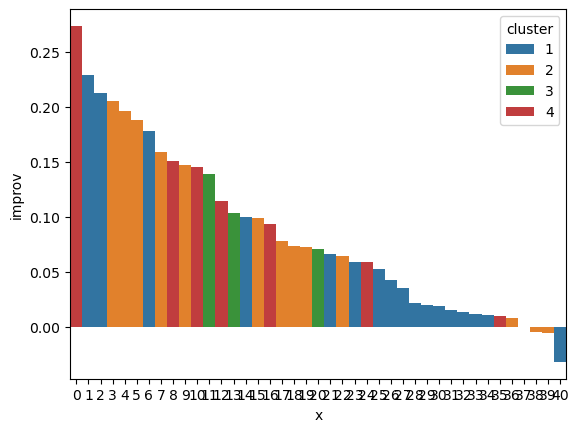

In [42]:
sns.barplot(x=x,y=y, hue=color,  data=results_sorted, width=1)
plt.show()